<a href="https://colab.research.google.com/github/FlameDanita/Neural_Networks_and_CV/blob/master/module03_wine_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
import random
while True:
    num = random.randint(0, 1e6)
    random.seed(num)
    if random.randint(0, 10) == 5:
        print(num)
        break

738938


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [11]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        # x = self.fc2(x)
        # x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [12]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [13]:
np.random.permutation(5)

array([1, 2, 4, 3, 0])

In [14]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.2407)
tensor(0.5185)
tensor(0.4815)
tensor(0.4815)
tensor(0.6296)
tensor(0.6296)
tensor(0.7222)
tensor(0.7778)
tensor(0.7778)
tensor(0.7593)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)


KeyboardInterrupt: ignored

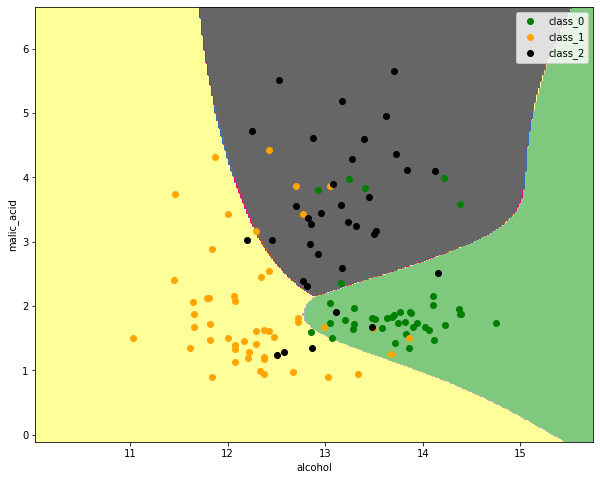

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Всем привет, проводил эксперимент следующим образом:

1) Количество нейронов в скрытых слоях

Обучил нейросеть с количеством нейронов в скрытых слоях от 1 до 19 по 10 раз, и затем вывел на график accuracy каждого обучения + медианы по каждому количеству нейронов в скрытых слоях:



Итого получается, что начиная с 9-10 нейронов accuracy во первых практически не растет, а во вторых результат воспроизводимый (меньший разброс). Если брать >= 15 нейронов, даже минимальные значения уже не сильно отличаются от медианы (хотя, конечно, заивисит от цели при решении задачи).

2) Зависимость результата от test size

Base rate = 39,9%

Обучил нейросеть с 10 нейронами в скрытых слоях с test size от 0.05 до 0.95 с шагом 0.05 (по 10 раз) , и затем вывел на график accuracy каждого обучения + медианы по каждому test size:



При сильном увеличении test size происходит уменьшение train dataset и видим как падает accuracy. Я ожидал, что эффект будет проявляться раньше, а не при >0.5. Видим что при таком размере датасета с точки зрения медианной оценки 0,25-0,4 - вполне адекватный размер test датасет.

3) Зависимость скорости обучения от batch size

От batch size очень сильно зависит скорость обучения, если он маленький - то мы неиспользуем возможности параллельных вычислений. Провел эксперимент: обучал нейросеть с batch_size = 2^t, t=0,1,2...8. Брать t>8 в данном случае смысла не имеет, т.к. всего в датасете элементов <256

Получилась следующая картина:



Зависимость от t (предполагал, что будет линейная, но нет):



Итого - если есть возможность (хватает памяти), то стоит увеличивать batch size.